In [ ]:
# Bloco 1 ‚Äì Instala√ß√£o de depend√™ncias
!pip install pandas numpy scikit-learn imblearn statsmodels matplotlib seaborn streamlit


In [ ]:
# Bloco 2 ‚Äì Importa√ß√µes e Configura√ß√µes

# 1) Controle de warnings e logs
import warnings
warnings.filterwarnings("ignore")               # Suprime FutureWarnings e similares
import logging
logging.getLogger("streamlit").setLevel(logging.ERROR)

# 2) Bibliotecas gerais
import os
import pandas as pd
import numpy as np

# 3) Visualiza√ß√£o (notebook e app)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 4) Modelagem e pr√©-processamento
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.linear_model          import LogisticRegression
from sklearn.feature_selection     import RFE
from sklearn.metrics               import (
    roc_auc_score, roc_curve,
    confusion_matrix,
    classification_report,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling        import SMOTE
import statsmodels.api             as sm

# 5) Estat√≠stica complementar
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 6) Dashboard interativo
import streamlit as st
st.set_page_config(page_title="Dashboard de Cancelamentos", layout="wide")

# 7) Constantes
RANDOM_STATE = 42
TEST_SIZE    = 0.3


2025-06-16 23:00:30.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
# Bloco 3 ‚Äì Carregamento do CSV e Resumo R√°pido

# Detecta automaticamente onde est√° o arquivo
if os.path.exists('/content/sample_data/hotel_bookings.csv'):
    path = '/content/sample_data/hotel_bookings.csv'
elif os.path.exists('hotel_bookings.csv'):
    path = 'hotel_bookings.csv'
else:
    raise FileNotFoundError("Arquivo 'hotel_bookings.csv' n√£o encontrado.")

# Carrega o DataFrame, j√° parseando datas
df = pd.read_csv(path, parse_dates=['reservation_status_date'])

# Exibe apenas um resumo enxuto
print("Shape:", df.shape)
print("\nColunas:", df.columns.tolist())
print("\nMissings por coluna:\n", df.isna().sum())
print("\nDistribui√ß√£o de is_canceled (propor√ß√£o):")
print(df['is_canceled'].value_counts(normalize=True).round(3))
print("\nAmostra das 5 primeiras linhas:")
print(df.head(5))


Shape: (119390, 32)

Colunas: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date']

Missings por coluna:
 hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0


In [ ]:
# Bloco 4 ‚Äì Limpeza de outliers e tratamento de missing

def clean_data(df):
    """
    Remove registros inv√°lidos e trata valores faltantes:
    - Filtra tarifas di√°rias negativas (adr < 0)
    - Preenche missing em agent e company com 0 (reservas sem ag√™ncia/empresa)
    - Agrupa pa√≠ses fora do top 10 em 'Other'
    """
    # Remove outliers de ADR
    df = df[df['adr'] >= 0].copy()

    # Imputa missing de agent e company
    df['agent'].fillna(0, inplace=True)
    df['company'].fillna(0, inplace=True)

    # Agrupa pa√≠ses menos frequentes
    top_countries = df['country'].value_counts().nlargest(10).index
    df['country'] = df['country'].where(df['country'].isin(top_countries), 'Other')

    return df

# Aplica limpeza
df = clean_data(df)

# Resumo p√≥s-limpeza
print("Ap√≥s limpeza: Shape =", df.shape)
print("Missings remaining:\n", df.isna().sum())


Ap√≥s limpeza: Shape = (119389, 32)
Missings remaining:
 hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
custome

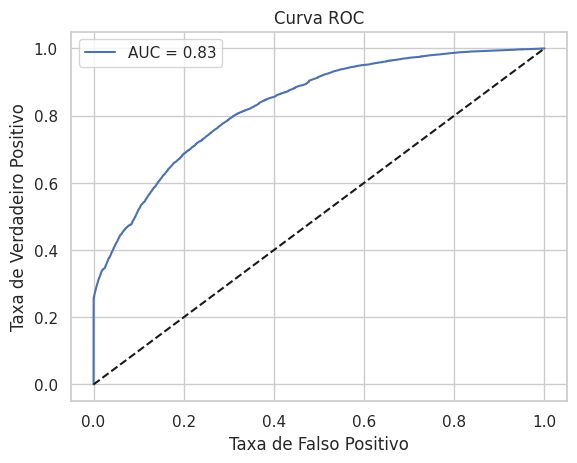

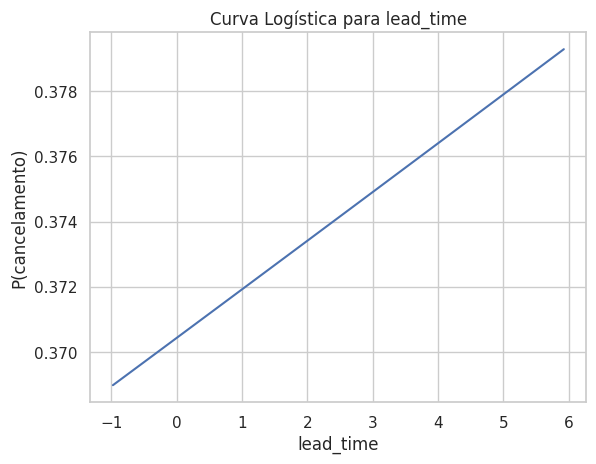

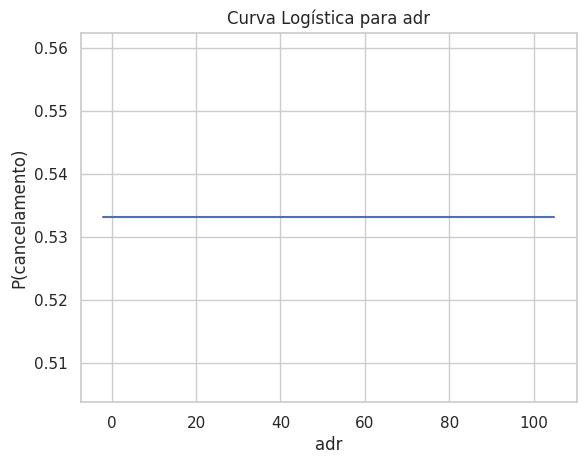

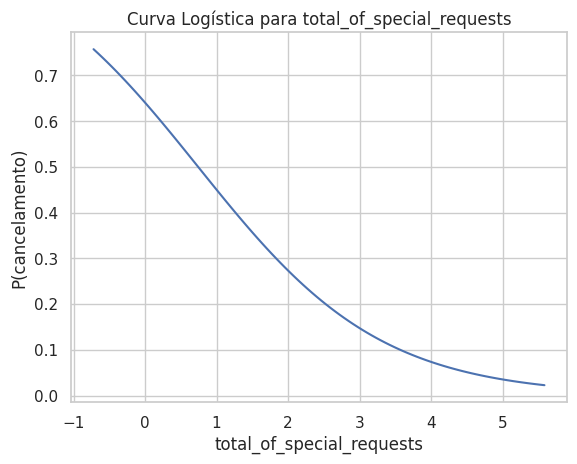

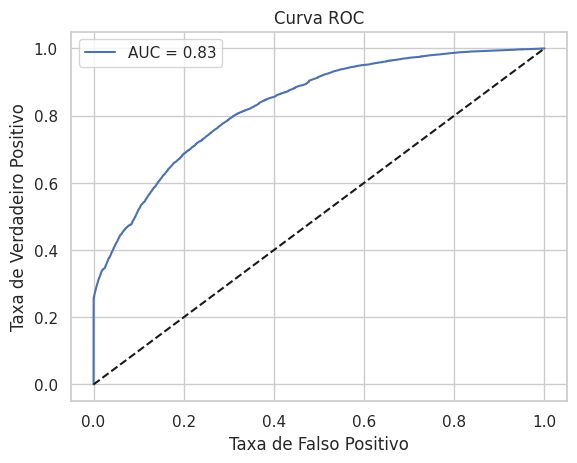

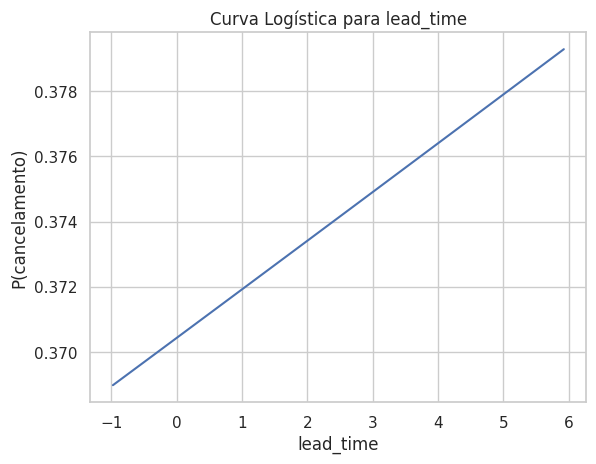

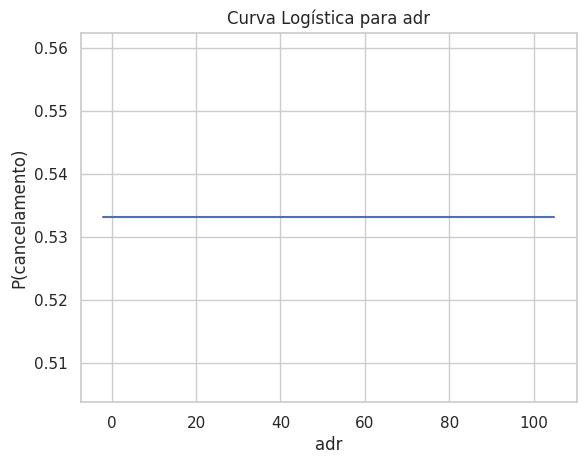

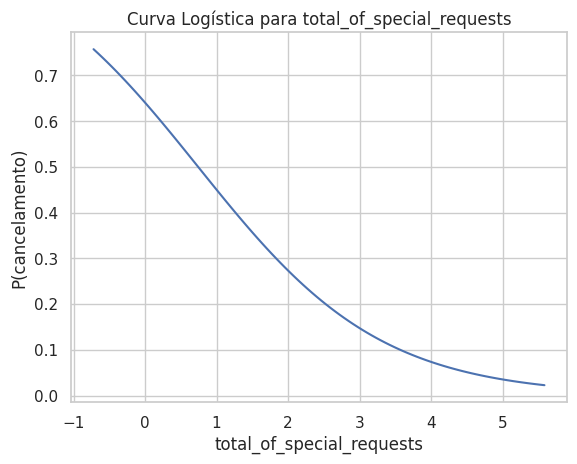

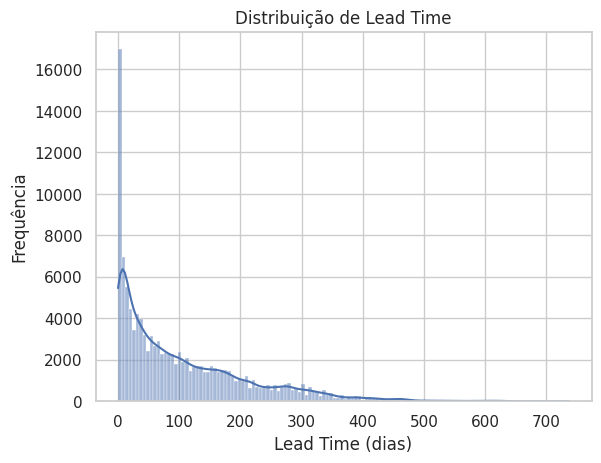

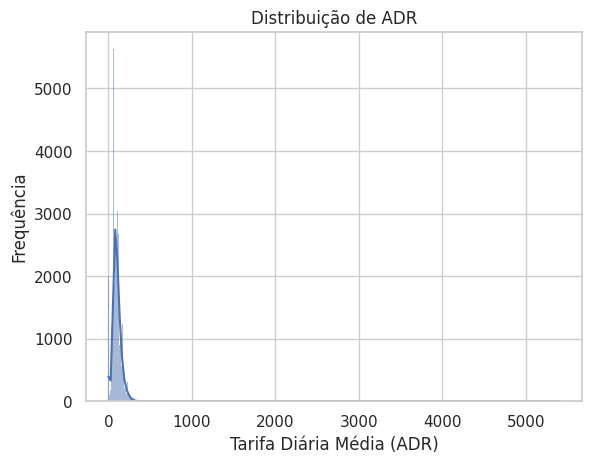

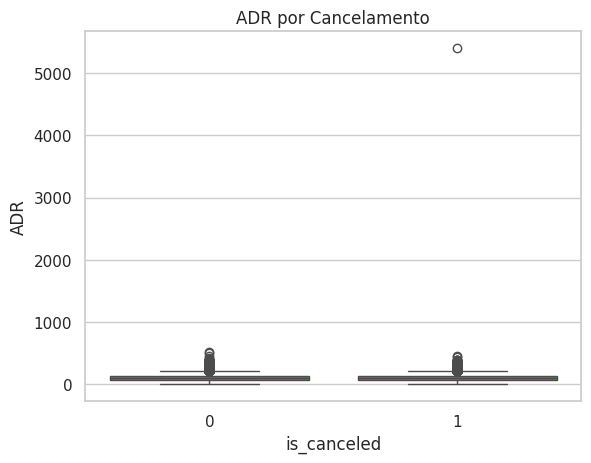

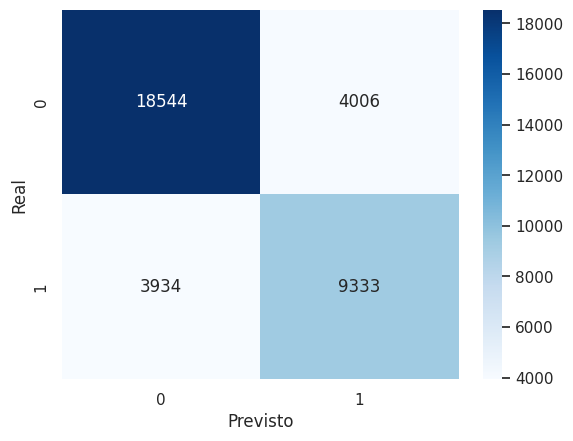

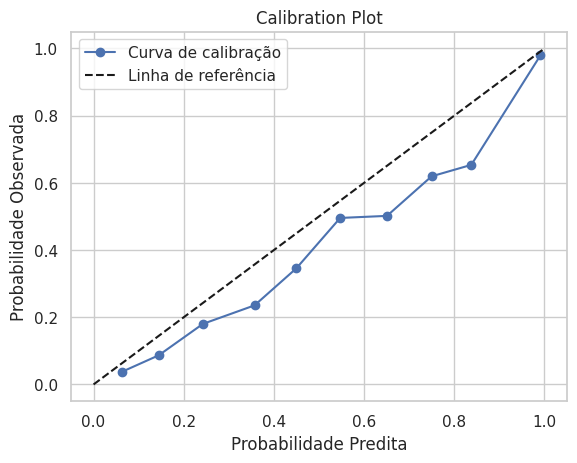

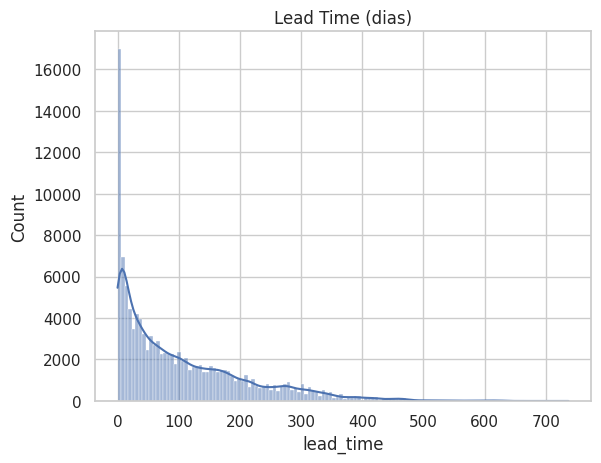

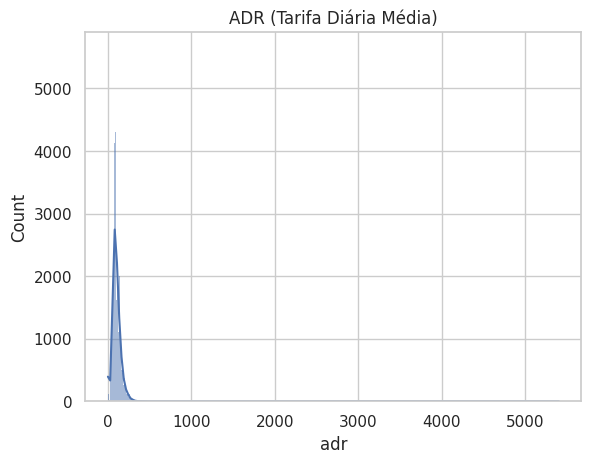

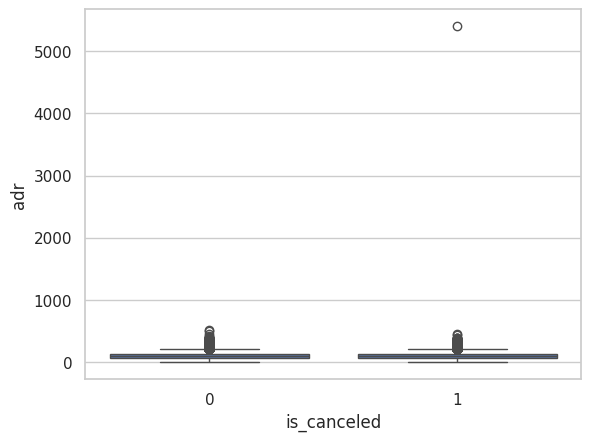

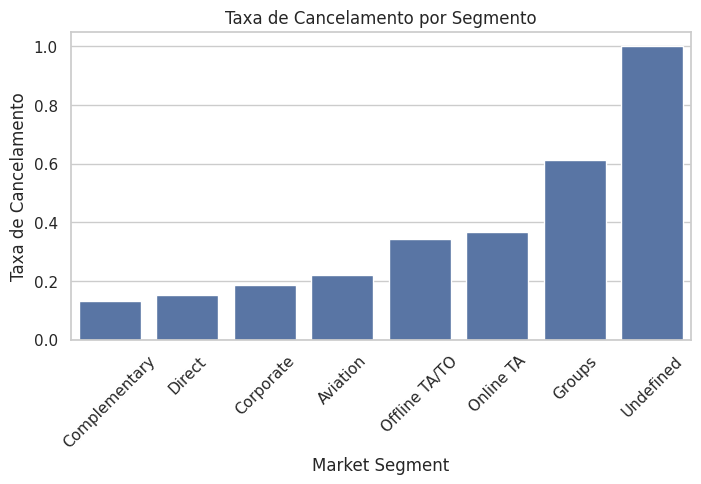

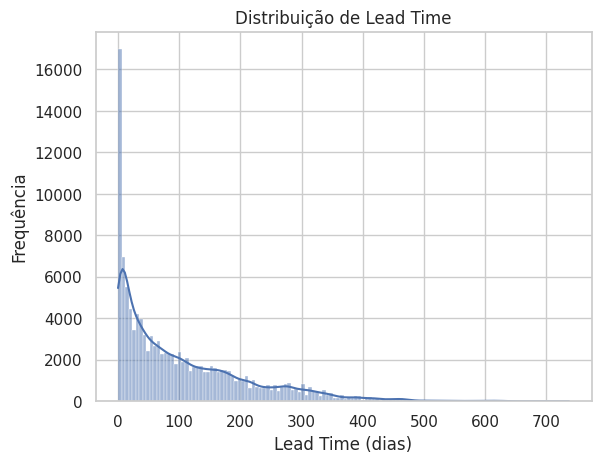

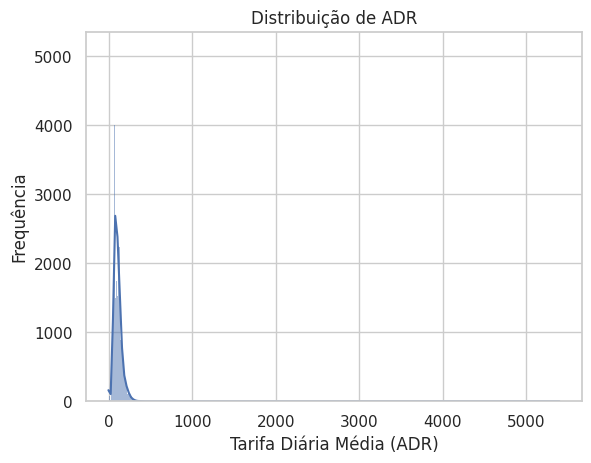

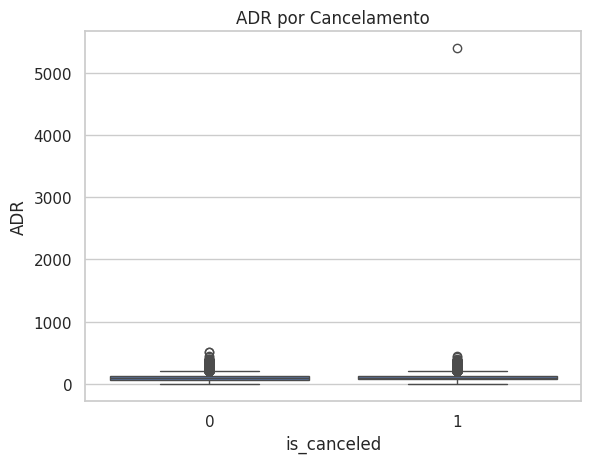

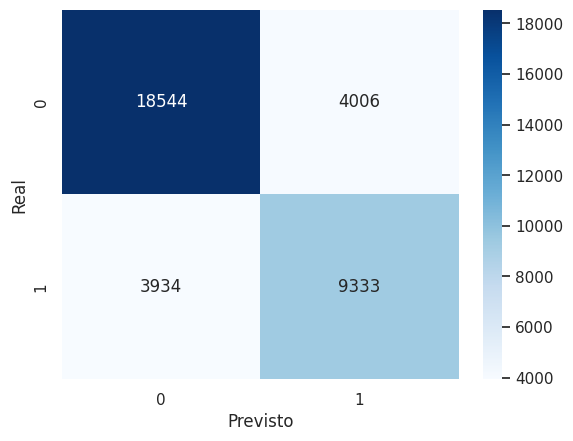

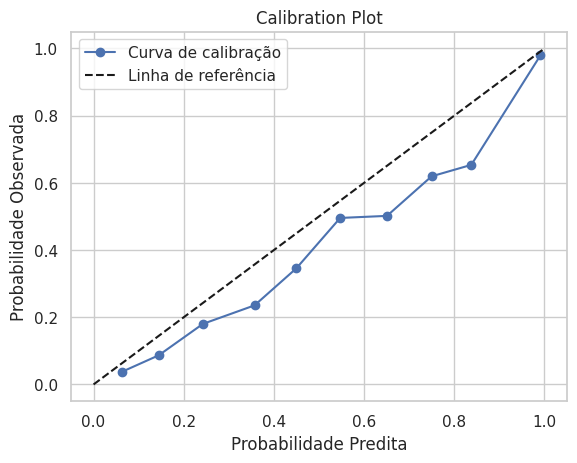

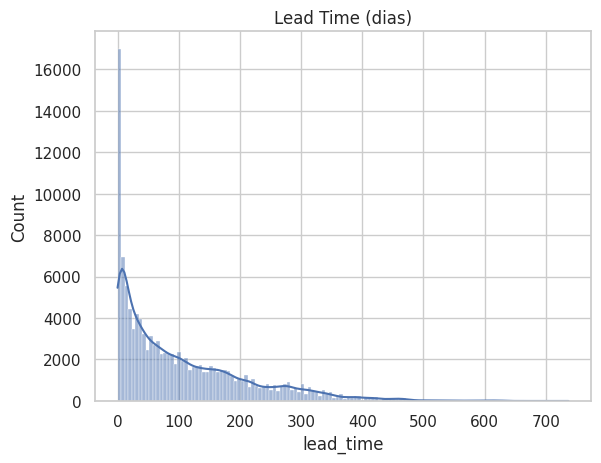

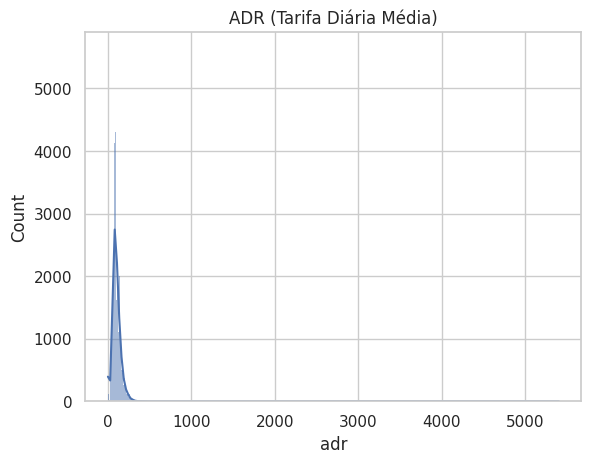

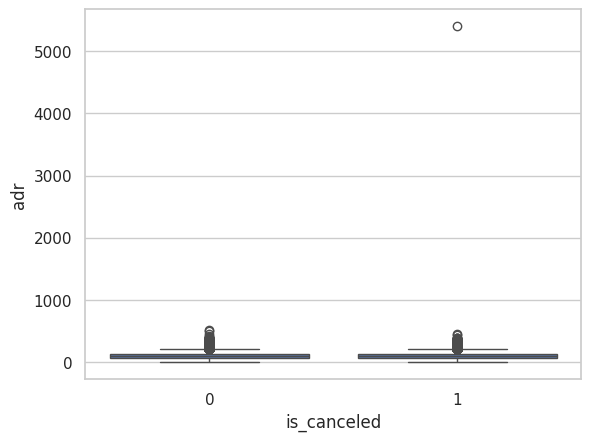

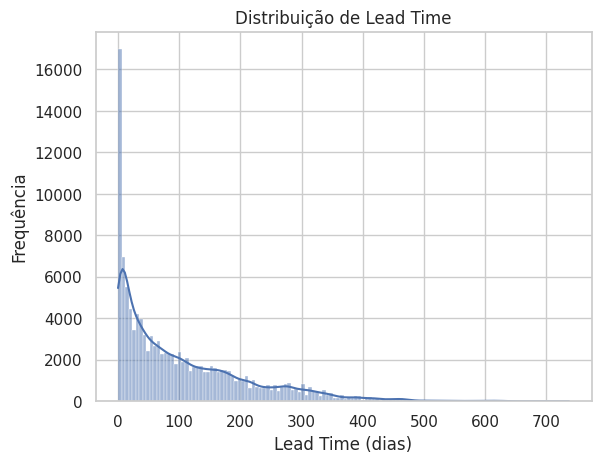

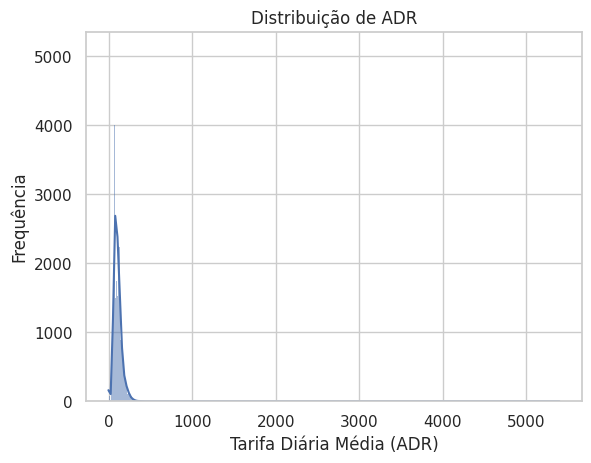

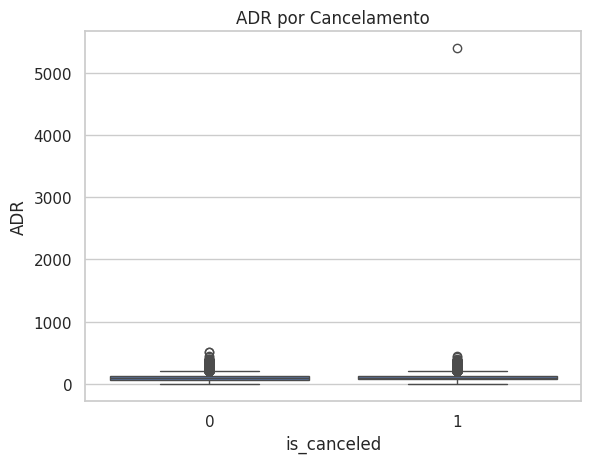

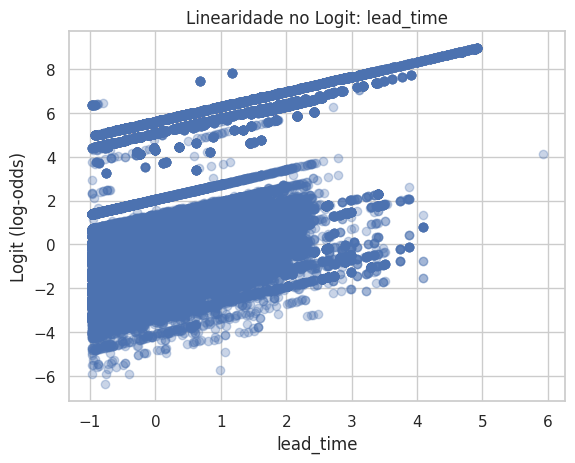

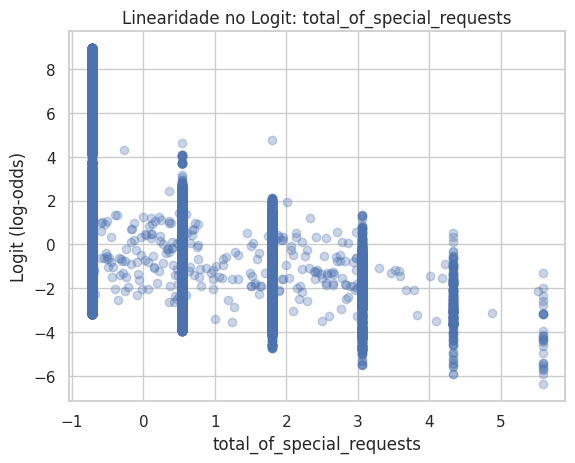

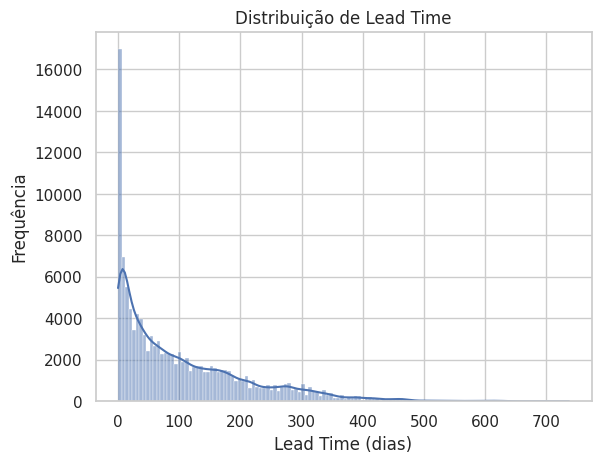

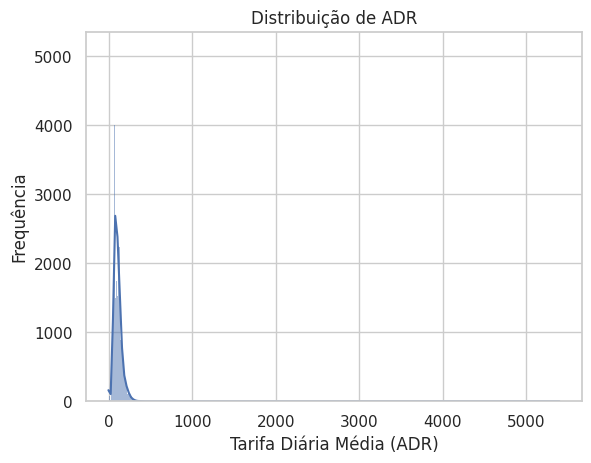

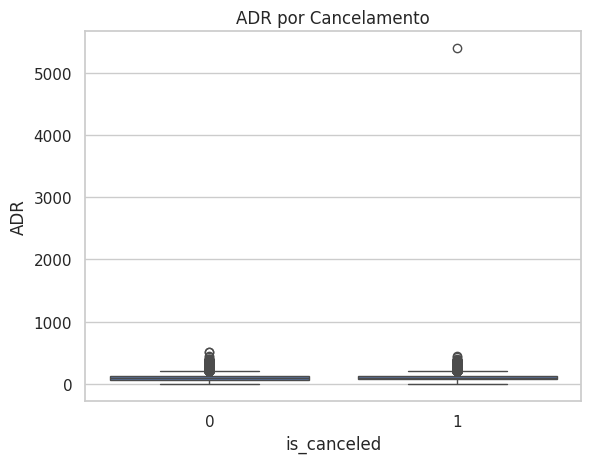

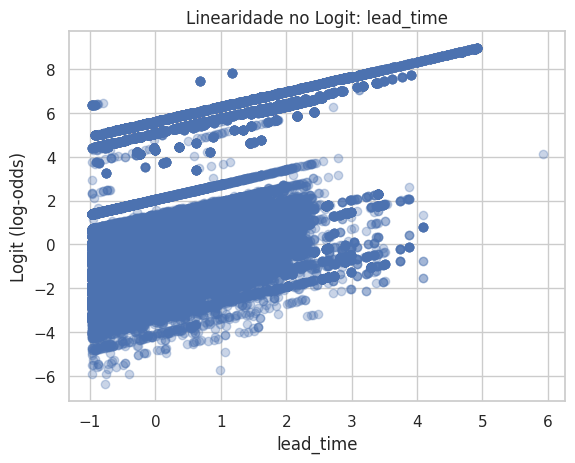

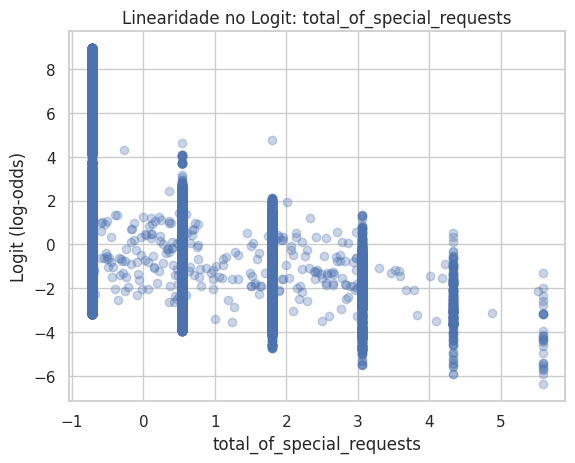

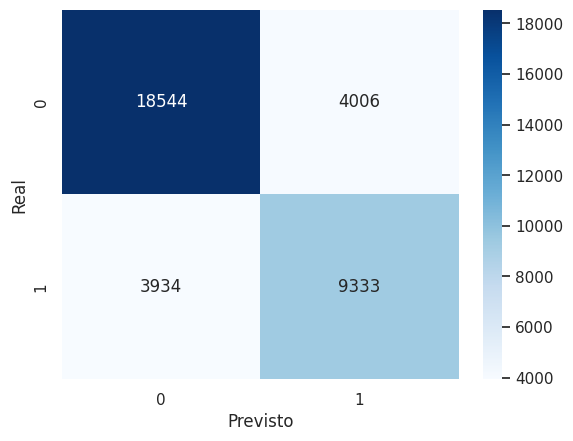

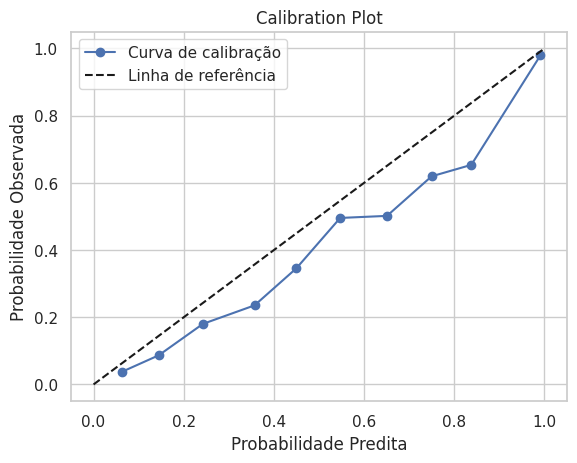

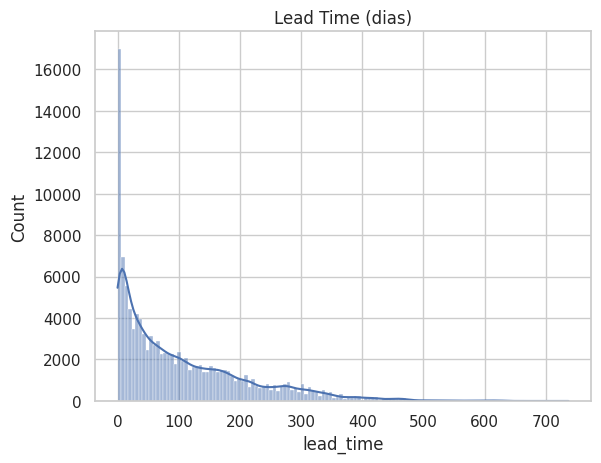

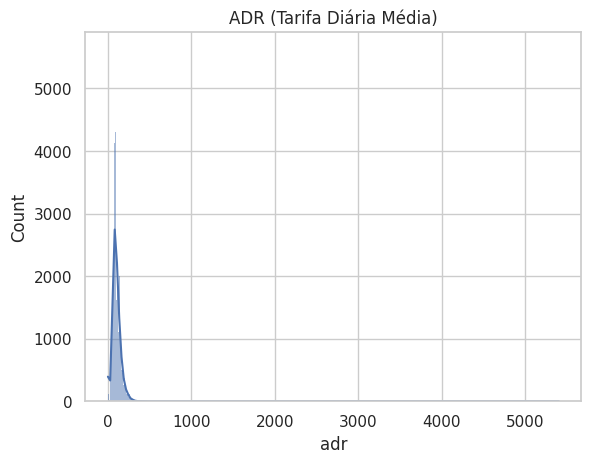

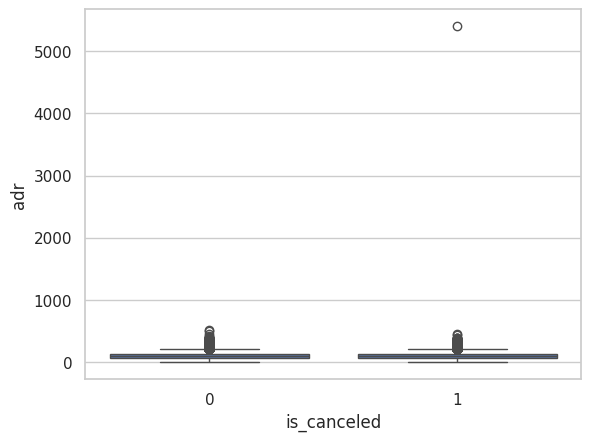

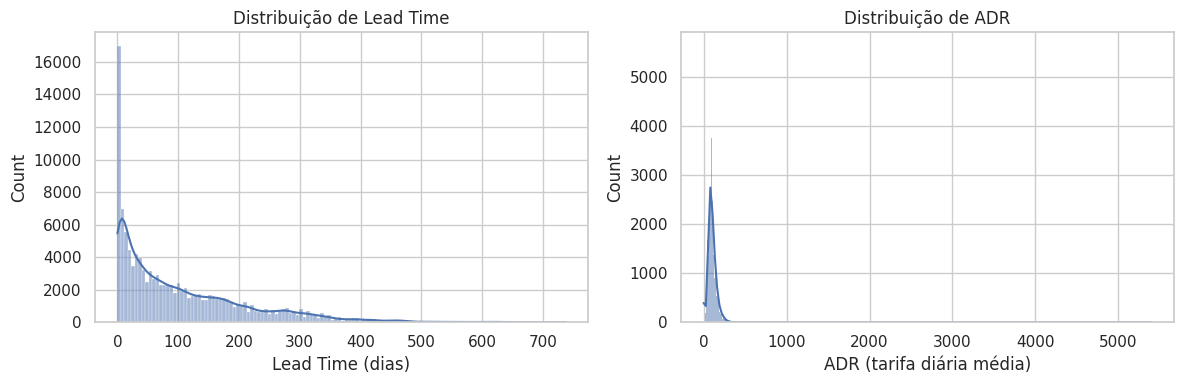

Taxa de cancelamento por Market Segment:
market_segment
Complementary    0.131
Direct           0.153
Corporate        0.187
Aviation         0.219
Offline TA/TO    0.343
Online TA        0.367
Groups           0.611
Undefined        1.000
Name: is_canceled, dtype: float64


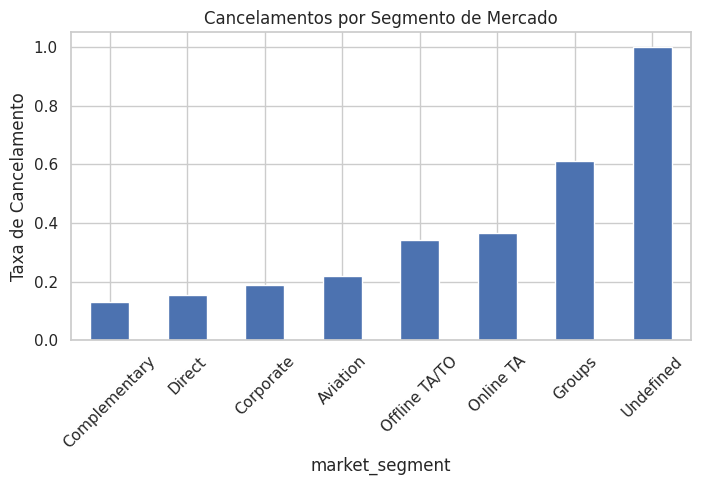


Taxa de cancelamento por M√™s de Chegada:
is_canceled            0     1
arrival_date_month            
April               0.59  0.41
August              0.62  0.38
December            0.65  0.35
February            0.67  0.33
January             0.70  0.30
July                0.63  0.37
June                0.59  0.41
March               0.68  0.32
May                 0.60  0.40
November            0.69  0.31
October             0.62  0.38
September           0.61  0.39


In [ ]:
# Bloco 5 ‚Äì EDA Est√°tico

# 1) Histogramas de vari√°veis cont√≠nuas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['lead_time'], kde=True, ax=axes[0])
axes[0].set_title('Distribui√ß√£o de Lead Time')
axes[0].set_xlabel('Lead Time (dias)')
sns.histplot(df['adr'], kde=True, ax=axes[1])
axes[1].set_title('Distribui√ß√£o de ADR')
axes[1].set_xlabel('ADR (tarifa di√°ria m√©dia)')
plt.tight_layout()
plt.show()

# 2) Taxa de cancelamento por Market Segment
seg_rate = df.groupby('market_segment')['is_canceled'].mean().sort_values()
print("Taxa de cancelamento por Market Segment:")
print(seg_rate.round(3))

# Gr√°fico de barras
fig, ax = plt.subplots(figsize=(8, 4))
seg_rate.plot.bar(ax=ax)
ax.set_ylabel('Taxa de Cancelamento')
ax.set_title('Cancelamentos por Segmento de Mercado')
plt.xticks(rotation=45)
plt.show()

# 3) Tabela de conting√™ncia resumida por m√™s de chegada
ct = pd.crosstab(
    df['arrival_date_month'],
    df['is_canceled'],
    normalize='index'
).round(2)
print("\nTaxa de cancelamento por M√™s de Chegada:")
print(ct)


In [ ]:
# Bloco 6 ‚Äì Pr√©-processamento: encoding, padroniza√ß√£o e defini√ß√£o de X e y

# 1) Defini√ß√£o de vari√°veis cont√≠nuas e categ√≥ricas
cont_vars = ['lead_time', 'adr', 'total_of_special_requests']
cat_vars  = ['hotel', 'arrival_date_month', 'market_segment', 'customer_type', 'deposit_type', 'country']

# 2) Sele√ß√£o do subset de features
df_features = df[cont_vars + cat_vars].copy()

# 3) One-hot encoding para vari√°veis categ√≥ricas
df_encoded = pd.get_dummies(df_features, columns=cat_vars, drop_first=True)

# 4) Padroniza√ß√£o das vari√°veis cont√≠nuas
scaler = StandardScaler()
df_encoded[cont_vars] = scaler.fit_transform(df_encoded[cont_vars])

# 5) Defini√ß√£o de X e y
X = df_encoded
y = df['is_canceled']

# 6) Resumo r√°pido
print("X shape:", X.shape)
print("Distribui√ß√£o de y (propor√ß√£o):\n", y.value_counts(normalize=True).round(3))
print("Exemplo de X.head():")
print(X.head())


X shape: (119389, 37)
Distribui√ß√£o de y (propor√ß√£o):
 is_canceled
0    0.63
1    0.37
Name: proportion, dtype: float64
Exemplo de X.head():
   lead_time       adr  total_of_special_requests  hotel_Resort Hotel  \
0   2.227056 -2.015086                  -0.720699                True   
1   5.923385 -2.015086                  -0.720699                True   
2  -0.907806 -0.530961                  -0.720699                True   
3  -0.851659 -0.530961                  -0.720699                True   
4  -0.842301 -0.075829                   0.540659                True   

   arrival_date_month_August  arrival_date_month_December  \
0                      False                        False   
1                      False                        False   
2                      False                        False   
3                      False                        False   
4                      False                        False   

   arrival_date_month_February  arrival_date_month

In [ ]:
# Bloco 7 ‚Äì Divis√£o treino/teste e tratamento de desbalanceamento (SMOTE)

# 1) Divis√£o estratificada com shuffle para reprodutibilidade
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    shuffle=True,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Conjuntos ap√≥s split:")
print(f"- X_train: {X_train.shape}   y_train: {y_train.shape}")
print(f"- X_test : {X_test.shape}   y_test : {y_test.shape}")
print("\nDistribui√ß√£o de y_train (propor√ß√£o):")
print(y_train.value_counts(normalize=True).round(3))

# 2) Aplica√ß√£o de SMOTE no conjunto de treino para equilibrar classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("\nAp√≥s SMOTE:")
print(f"- X_res : {X_res.shape}   y_res : {y_res.shape}")
print("Distribui√ß√£o de y_res (propor√ß√£o):")
print(y_res.value_counts(normalize=True).round(3))


Conjuntos ap√≥s split:
- X_train: (83572, 37)   y_train: (83572,)
- X_test : (35817, 37)   y_test : (35817,)

Distribui√ß√£o de y_train (propor√ß√£o):
is_canceled
0    0.63
1    0.37
Name: proportion, dtype: float64

Ap√≥s SMOTE:
- X_res : (105230, 37)   y_res : (105230,)
Distribui√ß√£o de y_res (propor√ß√£o):
is_canceled
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
# Bloco 8 ‚Äì Sele√ß√£o de Features com RFE

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import pandas as pd

# 1) Modelo base para RFE
base_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# 2) Instancia e ajusta o RFE para selecionar as 12 vari√°veis mais importantes
rfe = RFE(estimator=base_model, n_features_to_select=12)
rfe.fit(X_res, y_res)

# 3) Extrai lista de features selecionadas
selected_features = X_res.columns[rfe.support_].tolist()
print("Features selecionadas pelo RFE (n=12):")
print(selected_features)

# 4) Ranking completo das vari√°veis
ranking_df = pd.DataFrame({
    'feature': X_res.columns,
    'ranking': rfe.ranking_
}).sort_values('ranking')
print("\nRanking de todas as vari√°veis (1 = mais importante):")
print(ranking_df)


Features selecionadas pelo RFE (n=12):
['lead_time', 'total_of_special_requests', 'market_segment_Groups', 'market_segment_Online TA', 'customer_type_Transient', 'deposit_type_Non Refund', 'country_BRA', 'country_ESP', 'country_IRL', 'country_ITA', 'country_Other', 'country_PRT']

Ranking de todas as vari√°veis (1 = mais importante):
                          feature  ranking
0                       lead_time        1
2       total_of_special_requests        1
29                    country_ESP        1
27                    country_BRA        1
25        deposit_type_Non Refund        1
23        customer_type_Transient        1
20       market_segment_Online TA        1
18          market_segment_Groups        1
36                    country_PRT        1
35                  country_Other        1
33                    country_ITA        1
32                    country_IRL        1
3              hotel_Resort Hotel        2
17          market_segment_Direct        3
19   market_segment

In [ ]:
# Bloco 9 ‚Äì Ajuste do modelo e extra√ß√£o de coeficientes

# 1) Sele√ß√£o de features e target
X_sel = X_res[selected_features]
y_sel = y_res

# 2) Garante que tudo √© float (elimina object dtypes)
X_sel = X_sel.astype(float)
y_sel = y_sel.astype(float)

# 3) Adiciona intercepto
X_sm = sm.add_constant(X_sel)

# 4) Ajusta o modelo Logit (MQP)
logit_model  = sm.Logit(y_sel, X_sm)
logit_result = logit_model.fit(disp=False)

# 5) Monta DataFrame de coeficientes, p-valores e odds ratios
coef_df = pd.DataFrame({
    'log_odds'   : logit_result.params,
    'p_value'    : logit_result.pvalues,
    'odds_ratio' : np.exp(logit_result.params)
}).sort_values('odds_ratio', ascending=False)

# 6) Exibe de forma enxuta
print("Coeficientes do Modelo (ordenados por odds_ratio):")
print(coef_df[['log_odds', 'p_value', 'odds_ratio']]
      .round({'log_odds': 3, 'p_value': 3, 'odds_ratio': 2}))


Coeficientes do Modelo (ordenados por odds_ratio):
                           log_odds  p_value  odds_ratio
deposit_type_Non Refund       4.956      0.0      141.96
country_PRT                   1.959      0.0        7.09
market_segment_Online TA      1.939      0.0        6.95
country_BRA                   1.005      0.0        2.73
country_ITA                   0.930      0.0        2.53
lead_time                     0.681      0.0        1.98
customer_type_Transient       0.669      0.0        1.95
country_ESP                   0.653      0.0        1.92
country_Other                 0.554      0.0        1.74
market_segment_Groups         0.536      0.0        1.71
country_IRL                   0.389      0.0        1.48
total_of_special_requests    -0.616      0.0        0.54
const                        -2.963      0.0        0.05


VIF das Features Selecionadas:
                      feature   VIF
4     customer_type_Transient  4.34
3    market_segment_Online TA  3.04
5     deposit_type_Non Refund  2.44
11                country_PRT  2.37
2       market_segment_Groups  1.82
10              country_Other  1.40
0                   lead_time  1.32
1   total_of_special_requests  1.22
7                 country_ESP  1.19
9                 country_ITA  1.08
8                 country_IRL  1.07
6                 country_BRA  1.06


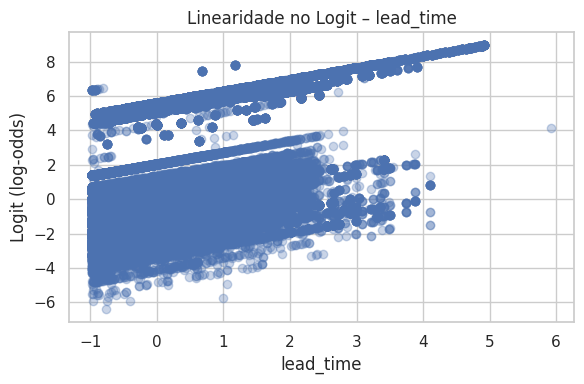

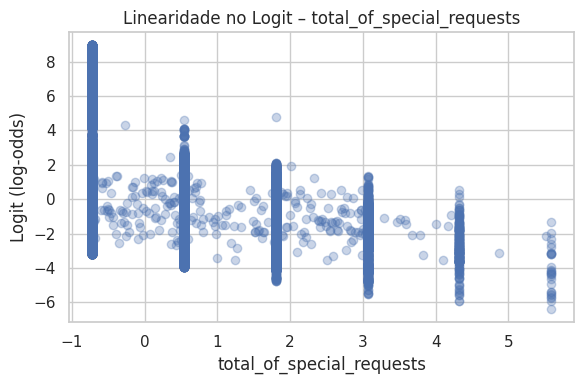

Pseudo-R¬≤ (McFadden): 0.335
AIC: 97050.6    BIC: 97175.0


In [ ]:
# Bloco 10 ‚Äì Diagn√≥sticos: VIF, Linearidade Gr√°fica e Qualidade de Ajuste

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Multicolinearidade ‚Äì VIF
X_vif = X_sel.copy()  # X_sel e y_sel definidos no Bloco 9
vif_df = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)
print("VIF das Features Selecionadas:")
print(vif_df.round(2))

# 2) Linearidade no Logit ‚Äì gr√°ficos de logit vs features cont√≠nuas
lin_pred = X_sm.dot(logit_result.params)  # X_sm e logit_result do Bloco 9
cont_in_model = [v for v in cont_vars if v in selected_features]

for var in cont_in_model:
    plt.figure(figsize=(6,4))
    plt.scatter(X_sel[var], lin_pred, alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("Logit (log-odds)")
    plt.title(f"Linearidade no Logit ‚Äì {var}")
    plt.tight_layout()
    plt.show()

# 3) Qualidade de Ajuste ‚Äì Pseudo-R¬≤ e AIC/BIC
print(f"Pseudo-R¬≤ (McFadden): {logit_result.prsquared:.3f}")
print(f"AIC: {logit_result.aic:.1f}    BIC: {logit_result.bic:.1f}")


M√©tricas no conjunto de teste:
 Acur√°cia : 0.778
 Precis√£o : 0.700
 Recall   : 0.703
 F1-score : 0.702
 AUC (ROC): 0.847


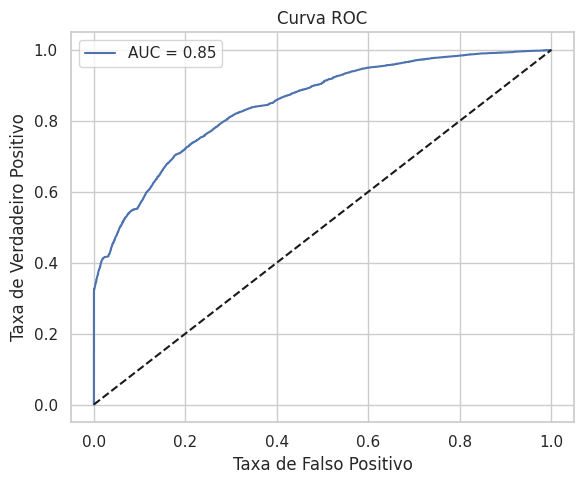

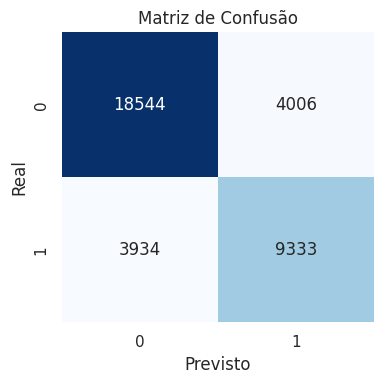

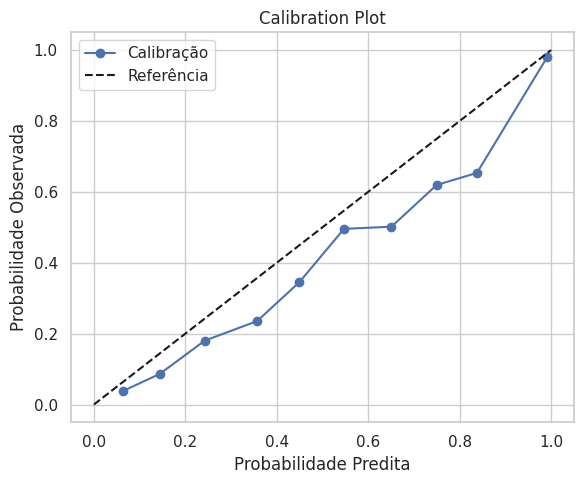

In [ ]:
# Bloco 11 ‚Äì Avalia√ß√£o preditiva: m√©tricas, ROC, matriz de confus√£o e calibration plot

from sklearn.linear_model      import LogisticRegression
from sklearn.metrics           import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.calibration       import calibration_curve
import matplotlib.pyplot       as plt
import seaborn                 as sns

# 1) Treina o classificador no conjunto balanceado
clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
clf.fit(X_res[selected_features], y_res)

# 2) Previs√µes no conjunto de teste
y_pred_prob = clf.predict_proba(X_test[selected_features])[:, 1]
y_pred      = (y_pred_prob >= 0.5).astype(int)

# 3) C√°lculo das m√©tricas principais
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
auc       = roc_auc_score(y_test, y_pred_prob)

print("M√©tricas no conjunto de teste:")
print(f" Acur√°cia : {accuracy:.3f}")
print(f" Precis√£o : {precision:.3f}")
print(f" Recall   : {recall:.3f}")
print(f" F1-score : {f1:.3f}")
print(f" AUC (ROC): {auc:.3f}")

# 4) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Matriz de Confus√£o (heatmap)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o")
plt.tight_layout()
plt.show()

# 6) Calibration Plot
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy='uniform')
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibra√ß√£o')
plt.plot([0,1],[0,1], 'k--', label='Refer√™ncia')
plt.xlabel("Probabilidade Predita")
plt.ylabel("Probabilidade Observada")
plt.title("Calibration Plot")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Bloco 12 ‚Äì App Streamlit: layout em abas, filtros e KPIs

# --- Sidebar de filtros ---
st.sidebar.header("Filtros de Entrada")

# Lead time
lead_min, lead_max = st.sidebar.slider(
    "Lead time (dias)",
    int(df['lead_time'].min()),
    int(df['lead_time'].max()),
    (int(df['lead_time'].quantile(0.1)), int(df['lead_time'].quantile(0.9)))
)

# Market segment
segments = st.sidebar.multiselect(
    "Market Segment",
    options=df['market_segment'].unique(),
    default=df['market_segment'].unique()
)

# Cutoff de decis√£o
cutoff = st.sidebar.slider(
    "Cutoff de Probabilidade",
    min_value=0.0, max_value=1.0,
    value=0.5, step=0.01
)

# --- Aplica filtros ---
mask = (
    (df['lead_time'] >= lead_min) &
    (df['lead_time'] <= lead_max) &
    (df['market_segment'].isin(segments))
)
df_filt = df.loc[mask]

# Prepara Xf e probabilidades
Xf = df_encoded.loc[df_filt.index, selected_features]
yf_prob = clf.predict_proba(Xf[selected_features])[:, 1]
df_filt = df_filt.assign(pred_cancel_prob=yf_prob)

# Classifica√ß√£o de risco
df_filt['risk_level'] = pd.cut(
    df_filt['pred_cancel_prob'],
    bins=[0, 0.33, 0.66, 1.0],
    labels=['Baixo', 'M√©dio', 'Alto']
)

# --- Abas principais ---
tabs = st.tabs(["EDA", "Modelagem", "Dashboard"])

# Aba 1: EDA
with tabs[0]:
    st.header("üîç Explora√ß√£o de Dados")
    st.subheader("Cancelamentos por Segmento")
    seg_rate = df_filt['market_segment'].value_counts().reindex(segments).fillna(0)
    st.bar_chart(seg_rate)

    st.subheader("Histograma de Lead Time & ADR")
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df_filt['lead_time'], kde=True, ax=axes[0]).set(title="Lead Time")
    sns.histplot(df_filt['adr'], kde=True, ax=axes[1]).set(title="ADR")
    st.pyplot(fig)

    st.subheader("Classifica√ß√£o de Risco")
    st.dataframe(df_filt['risk_level'].value_counts(normalize=True)
                 .rename("Propor√ß√£o").to_frame().style.format("{:.2%}"))

# Aba 2: Modelagem
with tabs[1]:
    st.header("‚öôÔ∏è Modelagem e Diagn√≥sticos")
    st.subheader("Sele√ß√£o de Features")
    st.write("Manual:", cont_vars + cat_vars)
    st.write("RFE   :", selected_features)

    st.subheader("Coeficientes e Odds Ratios")
    st.dataframe(coef_df.round({'log_odds':3,'p_value':3,'odds_ratio':2}))

    st.subheader("VIF das Features Selecionadas")
    st.dataframe(vif_df.round(2))

    st.subheader("Ajuste do Modelo")
    st.write(f"Pseudo-R¬≤: {logit_result.prsquared:.3f}")
    st.write(f"AIC: {logit_result.aic:.0f}   BIC: {logit_result.bic:.0f}")

# Aba 3: Dashboard Interativo
with tabs[2]:
    st.header("üìä Avalia√ß√£o Preditiva")
    # M√©tricas com cutoff
    y_pred_thresh = (yf_prob >= cutoff).astype(int)
    precision = precision_score(df_filt['is_canceled'], y_pred_thresh)
    recall    = recall_score(df_filt['is_canceled'], y_pred_thresh)
    f1        = f1_score(df_filt['is_canceled'], y_pred_thresh)
    auc_val   = roc_auc_score(df_filt['is_canceled'], yf_prob)

    c1, c2, c3, c4 = st.columns(4)
    c1.metric("AUC", f"{auc_val:.2f}")
    c2.metric("Precis√£o", f"{precision:.2f}")
    c3.metric("Recall", f"{recall:.2f}")
    c4.metric("F1-score", f"{f1:.2f}")

    st.subheader(f"Matriz de Confus√£o (cutoff={cutoff:.2f})")
    cm = confusion_matrix(df_filt['is_canceled'], y_pred_thresh)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Previsto")
    ax.set_ylabel("Real")
    st.pyplot(fig)

    st.subheader("Curva ROC")
    plot_roc_curve(df_filt['is_canceled'], yf_prob)

    st.subheader("Curvas Log√≠sticas de Vari√°veis-Chave")
    for var in cont_vars:
        plot_logistic_curve(var, df_encoded, scaler, clf, selected_features, cont_vars)


2025-06-16 23:14:39.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.063 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.064 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar